Parallel CSC with a Spatial Mask
================================

This example compares the use of [parcbpdn.ParConvBPDN](http://sporco.rtfd.org/en/latest/modules/sporco.admm.parcbpdn.html#sporco.admm.parcbpdn.ParConvBPDN) with [cbpdn.ConvBPDNMaskDcpl](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDNMaskDcpl) for convolutional sparse coding with a spatial mask [[50]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2016-boundary). The example problem is inpainting of randomly distributed corruption of a greyscale image.

In [1]:
from __future__ import print_function
from builtins import input

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco.admm import tvl2
from sporco.admm import cbpdn
from sporco.admm import parcbpdn
from sporco import util
from sporco import metric
from sporco import plot
plot.config_notebook_plotting()

Load a reference image.

In [2]:
img = util.ExampleImages().image('monarch.png', zoom=0.25, scaled=True,
                                 gray=True, idxexp=np.s_[:, 160:672])

Create random mask and apply to reference image to obtain test image. (The call to ``numpy.random.seed`` ensures that the pseudo-random noise is reproducible.)

In [3]:
t = 0.5
np.random.seed(12345)
msk = np.random.randn(*(img.shape))
msk[np.abs(msk) > t] = 1
msk[np.abs(msk) < t] = 0
imgw = msk * img

Define pad and crop functions.

In [4]:
pn = 8
spad = lambda x:  np.pad(x, pn, mode='symmetric')
zpad = lambda x:  np.pad(x, pn, mode='constant')
crop = lambda x: x[pn:-pn, pn:-pn]

Construct padded mask and test image.

In [5]:
mskp = zpad(msk)
imgwp = spad(imgw)

$\ell_2$-TV denoising with a spatial mask as a non-linear lowpass filter. The highpass component is the difference between the test image and the lowpass component, multiplied by the mask for faster convergence of the convolutional sparse coding (see [[60]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2017-convolutional3)).

In [6]:
lmbda = 0.05
opt = tvl2.TVL2Denoise.Options({'Verbose': False, 'MaxMainIter': 200,
                                'DFidWeight': mskp, 'gEvalY': False,
                                'AutoRho': {'Enabled': True}})
b = tvl2.TVL2Denoise(imgwp, lmbda, opt)
sl = b.solve()
sh = mskp * (imgwp - sl)

Load dictionary.

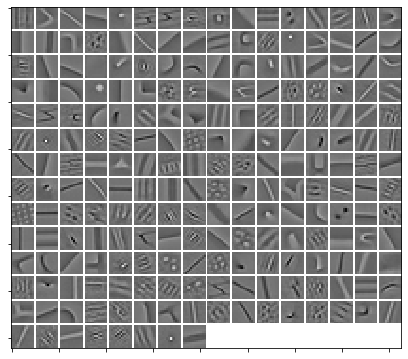

In [7]:
D = util.convdicts()['G:12x12x216']
plot.imview(util.tiledict(D), fgsz=(7, 7))

lmbda = 2e-2

The RelStopTol was chosen for the two different methods to stop with similar functional values

Initialise and run serial CSC solver using masked decoupling [[28]](http://sporco.rtfd.org/en/latest/zreferences.html#heide-2015-fast).

In [8]:
opt = cbpdn.ConvBPDNMaskDcpl.Options({'Verbose': True, 'MaxMainIter': 200,
                            'HighMemSolve': True, 'RelStopTol': 5e-2,
                            'AuxVarObj': False, 'RelaxParam': 1.8,
                            'rho': 5e1*lmbda + 1e-1, 'AutoRho':
                            {'Enabled': False, 'StdResiduals': False}})
b = cbpdn.ConvBPDNMaskDcpl(D, sh, lmbda, mskp, opt=opt)
X = b.solve()

Itn   Fnc       DFid      Regℓ1     r         s       
------------------------------------------------------


   0  1.20e+01  5.44e-03  5.98e+02  1.06e-01  9.64e-01


   1  1.09e+01  3.73e-02  5.44e+02  9.75e-02  1.16e+00


   2  1.01e+01  7.97e-02  5.00e+02  9.15e-02  1.16e+00


   3  9.65e+00  1.15e-01  4.77e+02  8.79e-02  1.05e+00


   4  9.54e+00  1.37e-01  4.70e+02  8.57e-02  9.00e-01


   5  9.55e+00  1.50e-01  4.70e+02  8.35e-02  7.61e-01


   6  9.50e+00  1.59e-01  4.67e+02  7.97e-02  6.53e-01


   7  9.39e+00  1.66e-01  4.61e+02  7.59e-02  5.76e-01


   8  9.27e+00  1.73e-01  4.55e+02  7.26e-02  5.16e-01


   9  9.20e+00  1.81e-01  4.51e+02  6.98e-02  4.62e-01


  10  9.20e+00  1.89e-01  4.51e+02  6.73e-02  4.13e-01


  11  9.17e+00  1.98e-01  4.49e+02  6.48e-02  3.72e-01


  12  9.15e+00  2.07e-01  4.47e+02  6.24e-02  3.39e-01


  13  9.11e+00  2.14e-01  4.45e+02  6.02e-02  3.13e-01


  14  9.06e+00  2.18e-01  4.42e+02  5.81e-02  2.93e-01


  15  9.00e+00  2.21e-01  4.39e+02  5.62e-02  2.80e-01


  16  8.90e+00  2.22e-01  4.34e+02  5.43e-02  2.72e-01


  17  8.78e+00  2.22e-01  4.28e+02  5.26e-02  2.67e-01


  18  8.63e+00  2.22e-01  4.21e+02  5.09e-02  2.63e-01


  19  8.52e+00  2.22e-01  4.15e+02  4.96e-02  2.58e-01


  20  8.40e+00  2.24e-01  4.09e+02  4.82e-02  2.52e-01


  21  8.28e+00  2.26e-01  4.03e+02  4.69e-02  2.46e-01


  22  8.17e+00  2.30e-01  3.97e+02  4.58e-02  2.41e-01


  23  8.07e+00  2.33e-01  3.92e+02  4.47e-02  2.35e-01


  24  7.98e+00  2.36e-01  3.87e+02  4.37e-02  2.30e-01


  25  7.91e+00  2.40e-01  3.83e+02  4.28e-02  2.26e-01


  26  7.84e+00  2.43e-01  3.80e+02  4.20e-02  2.22e-01


  27  7.77e+00  2.46e-01  3.76e+02  4.11e-02  2.18e-01


  28  7.70e+00  2.49e-01  3.73e+02  4.03e-02  2.15e-01


  29  7.63e+00  2.52e-01  3.69e+02  3.95e-02  2.12e-01


  30  7.55e+00  2.54e-01  3.65e+02  3.88e-02  2.08e-01


  31  7.46e+00  2.57e-01  3.60e+02  3.81e-02  2.04e-01


  32  7.37e+00  2.60e-01  3.55e+02  3.74e-02  2.00e-01


  33  7.27e+00  2.64e-01  3.50e+02  3.67e-02  1.96e-01


  34  7.18e+00  2.67e-01  3.46e+02  3.60e-02  1.92e-01


  35  7.10e+00  2.70e-01  3.41e+02  3.54e-02  1.87e-01


  36  7.02e+00  2.73e-01  3.37e+02  3.47e-02  1.83e-01


  37  6.97e+00  2.76e-01  3.35e+02  3.41e-02  1.78e-01


  38  6.93e+00  2.79e-01  3.32e+02  3.36e-02  1.73e-01


  39  6.89e+00  2.81e-01  3.31e+02  3.30e-02  1.69e-01


  40  6.86e+00  2.83e-01  3.29e+02  3.24e-02  1.65e-01


  41  6.82e+00  2.85e-01  3.27e+02  3.19e-02  1.62e-01


  42  6.78e+00  2.87e-01  3.25e+02  3.14e-02  1.59e-01


  43  6.75e+00  2.89e-01  3.23e+02  3.09e-02  1.56e-01


  44  6.72e+00  2.90e-01  3.21e+02  3.04e-02  1.53e-01


  45  6.68e+00  2.92e-01  3.19e+02  2.99e-02  1.50e-01


  46  6.64e+00  2.93e-01  3.17e+02  2.95e-02  1.48e-01


  47  6.59e+00  2.94e-01  3.15e+02  2.91e-02  1.46e-01


  48  6.53e+00  2.95e-01  3.12e+02  2.86e-02  1.44e-01


  49  6.48e+00  2.96e-01  3.09e+02  2.82e-02  1.42e-01


  50  6.41e+00  2.97e-01  3.06e+02  2.78e-02  1.41e-01


  51  6.36e+00  2.98e-01  3.03e+02  2.74e-02  1.39e-01


  52  6.30e+00  3.00e-01  3.00e+02  2.70e-02  1.38e-01


  53  6.25e+00  3.01e-01  2.97e+02  2.66e-02  1.37e-01


  54  6.20e+00  3.03e-01  2.95e+02  2.62e-02  1.36e-01


  55  6.16e+00  3.05e-01  2.93e+02  2.59e-02  1.34e-01


  56  6.11e+00  3.06e-01  2.90e+02  2.55e-02  1.33e-01


  57  6.07e+00  3.08e-01  2.88e+02  2.52e-02  1.32e-01


  58  6.03e+00  3.09e-01  2.86e+02  2.49e-02  1.31e-01


  59  5.99e+00  3.11e-01  2.84e+02  2.45e-02  1.29e-01


  60  5.97e+00  3.12e-01  2.83e+02  2.42e-02  1.28e-01


  61  5.94e+00  3.13e-01  2.81e+02  2.39e-02  1.26e-01


  62  5.92e+00  3.14e-01  2.80e+02  2.36e-02  1.24e-01


  63  5.90e+00  3.15e-01  2.79e+02  2.33e-02  1.23e-01


  64  5.87e+00  3.16e-01  2.78e+02  2.31e-02  1.21e-01


  65  5.85e+00  3.17e-01  2.76e+02  2.28e-02  1.19e-01


  66  5.82e+00  3.18e-01  2.75e+02  2.25e-02  1.18e-01


  67  5.80e+00  3.19e-01  2.74e+02  2.23e-02  1.16e-01


  68  5.77e+00  3.19e-01  2.73e+02  2.20e-02  1.14e-01


  69  5.75e+00  3.20e-01  2.72e+02  2.17e-02  1.13e-01


  70  5.73e+00  3.20e-01  2.71e+02  2.15e-02  1.12e-01


  71  5.71e+00  3.21e-01  2.69e+02  2.12e-02  1.10e-01


  72  5.68e+00  3.21e-01  2.68e+02  2.10e-02  1.09e-01


  73  5.65e+00  3.21e-01  2.67e+02  2.07e-02  1.08e-01


  74  5.63e+00  3.22e-01  2.65e+02  2.05e-02  1.07e-01


  75  5.60e+00  3.22e-01  2.64e+02  2.02e-02  1.06e-01


  76  5.58e+00  3.22e-01  2.63e+02  2.00e-02  1.05e-01


  77  5.56e+00  3.23e-01  2.62e+02  1.98e-02  1.03e-01


  78  5.54e+00  3.23e-01  2.61e+02  1.97e-02  1.02e-01


  79  5.52e+00  3.24e-01  2.60e+02  1.95e-02  1.01e-01


  80  5.50e+00  3.24e-01  2.59e+02  1.93e-02  9.95e-02


  81  5.47e+00  3.25e-01  2.57e+02  1.91e-02  9.83e-02


  82  5.44e+00  3.25e-01  2.56e+02  1.89e-02  9.73e-02


  83  5.41e+00  3.26e-01  2.54e+02  1.87e-02  9.64e-02


  84  5.38e+00  3.27e-01  2.52e+02  1.86e-02  9.56e-02


  85  5.35e+00  3.27e-01  2.51e+02  1.84e-02  9.49e-02


  86  5.32e+00  3.28e-01  2.50e+02  1.82e-02  9.42e-02


  87  5.30e+00  3.29e-01  2.48e+02  1.80e-02  9.36e-02


  88  5.28e+00  3.30e-01  2.47e+02  1.79e-02  9.30e-02


  89  5.26e+00  3.30e-01  2.46e+02  1.77e-02  9.24e-02


  90  5.24e+00  3.31e-01  2.45e+02  1.76e-02  9.17e-02


  91  5.22e+00  3.31e-01  2.44e+02  1.74e-02  9.11e-02


  92  5.20e+00  3.32e-01  2.44e+02  1.73e-02  9.04e-02


  93  5.19e+00  3.32e-01  2.43e+02  1.71e-02  8.96e-02


  94  5.18e+00  3.33e-01  2.42e+02  1.70e-02  8.89e-02


  95  5.17e+00  3.33e-01  2.42e+02  1.69e-02  8.81e-02


  96  5.15e+00  3.34e-01  2.41e+02  1.67e-02  8.72e-02


  97  5.14e+00  3.34e-01  2.40e+02  1.66e-02  8.64e-02


  98  5.13e+00  3.35e-01  2.40e+02  1.65e-02  8.56e-02


  99  5.11e+00  3.35e-01  2.39e+02  1.64e-02  8.49e-02


 100  5.09e+00  3.36e-01  2.38e+02  1.62e-02  8.42e-02


 101  5.07e+00  3.36e-01  2.37e+02  1.61e-02  8.36e-02


 102  5.05e+00  3.37e-01  2.36e+02  1.60e-02  8.30e-02


 103  5.03e+00  3.38e-01  2.35e+02  1.59e-02  8.25e-02


 104  5.01e+00  3.38e-01  2.34e+02  1.57e-02  8.19e-02


 105  4.99e+00  3.39e-01  2.33e+02  1.56e-02  8.14e-02


 106  4.97e+00  3.39e-01  2.32e+02  1.55e-02  8.08e-02


 107  4.96e+00  3.40e-01  2.31e+02  1.53e-02  8.03e-02


 108  4.94e+00  3.40e-01  2.30e+02  1.52e-02  7.97e-02


 109  4.93e+00  3.41e-01  2.29e+02  1.51e-02  7.91e-02


 110  4.91e+00  3.41e-01  2.29e+02  1.50e-02  7.86e-02


 111  4.90e+00  3.41e-01  2.28e+02  1.48e-02  7.81e-02


 112  4.88e+00  3.42e-01  2.27e+02  1.47e-02  7.76e-02


 113  4.87e+00  3.42e-01  2.26e+02  1.46e-02  7.71e-02


 114  4.85e+00  3.42e-01  2.25e+02  1.45e-02  7.66e-02


 115  4.84e+00  3.43e-01  2.25e+02  1.44e-02  7.62e-02


 116  4.82e+00  3.43e-01  2.24e+02  1.43e-02  7.58e-02


 117  4.81e+00  3.43e-01  2.23e+02  1.41e-02  7.54e-02


 118  4.79e+00  3.43e-01  2.22e+02  1.40e-02  7.50e-02


 119  4.78e+00  3.44e-01  2.22e+02  1.39e-02  7.45e-02


 120  4.77e+00  3.44e-01  2.21e+02  1.38e-02  7.40e-02


 121  4.76e+00  3.44e-01  2.21e+02  1.37e-02  7.35e-02


 122  4.75e+00  3.44e-01  2.20e+02  1.36e-02  7.29e-02


 123  4.74e+00  3.45e-01  2.20e+02  1.35e-02  7.22e-02


 124  4.73e+00  3.45e-01  2.19e+02  1.34e-02  7.15e-02


 125  4.72e+00  3.45e-01  2.19e+02  1.33e-02  7.07e-02


 126  4.71e+00  3.45e-01  2.18e+02  1.32e-02  6.99e-02


 127  4.71e+00  3.45e-01  2.18e+02  1.31e-02  6.92e-02


 128  4.70e+00  3.46e-01  2.18e+02  1.30e-02  6.84e-02


 129  4.68e+00  3.46e-01  2.17e+02  1.29e-02  6.77e-02


 130  4.67e+00  3.46e-01  2.16e+02  1.29e-02  6.71e-02


 131  4.66e+00  3.46e-01  2.16e+02  1.28e-02  6.65e-02


 132  4.65e+00  3.47e-01  2.15e+02  1.27e-02  6.60e-02


 133  4.63e+00  3.47e-01  2.14e+02  1.26e-02  6.55e-02


 134  4.62e+00  3.47e-01  2.14e+02  1.25e-02  6.52e-02


 135  4.61e+00  3.47e-01  2.13e+02  1.24e-02  6.49e-02


 136  4.59e+00  3.47e-01  2.12e+02  1.23e-02  6.46e-02


 137  4.58e+00  3.47e-01  2.11e+02  1.22e-02  6.44e-02


 138  4.56e+00  3.48e-01  2.11e+02  1.21e-02  6.42e-02


 139  4.55e+00  3.48e-01  2.10e+02  1.21e-02  6.39e-02


 140  4.54e+00  3.48e-01  2.09e+02  1.20e-02  6.37e-02


 141  4.53e+00  3.48e-01  2.09e+02  1.19e-02  6.34e-02


 142  4.52e+00  3.49e-01  2.08e+02  1.18e-02  6.31e-02


 143  4.51e+00  3.49e-01  2.08e+02  1.18e-02  6.27e-02


 144  4.50e+00  3.49e-01  2.08e+02  1.17e-02  6.23e-02


 145  4.50e+00  3.49e-01  2.07e+02  1.16e-02  6.18e-02


 146  4.49e+00  3.50e-01  2.07e+02  1.15e-02  6.13e-02


 147  4.49e+00  3.50e-01  2.07e+02  1.15e-02  6.08e-02


 148  4.48e+00  3.50e-01  2.07e+02  1.14e-02  6.03e-02


 149  4.48e+00  3.50e-01  2.06e+02  1.13e-02  5.98e-02


 150  4.47e+00  3.50e-01  2.06e+02  1.13e-02  5.94e-02


 151  4.46e+00  3.50e-01  2.05e+02  1.12e-02  5.90e-02


 152  4.45e+00  3.50e-01  2.05e+02  1.11e-02  5.87e-02


 153  4.44e+00  3.51e-01  2.04e+02  1.10e-02  5.85e-02


 154  4.42e+00  3.51e-01  2.04e+02  1.10e-02  5.83e-02


 155  4.41e+00  3.51e-01  2.03e+02  1.09e-02  5.82e-02


 156  4.40e+00  3.51e-01  2.02e+02  1.08e-02  5.81e-02


 157  4.38e+00  3.51e-01  2.02e+02  1.07e-02  5.80e-02


 158  4.37e+00  3.51e-01  2.01e+02  1.07e-02  5.79e-02


 159  4.36e+00  3.52e-01  2.01e+02  1.06e-02  5.78e-02


 160  4.35e+00  3.52e-01  2.00e+02  1.05e-02  5.76e-02


 161  4.34e+00  3.52e-01  2.00e+02  1.05e-02  5.74e-02


 162  4.34e+00  3.52e-01  1.99e+02  1.04e-02  5.71e-02


 163  4.33e+00  3.52e-01  1.99e+02  1.04e-02  5.68e-02


 164  4.32e+00  3.53e-01  1.98e+02  1.03e-02  5.65e-02


 165  4.31e+00  3.53e-01  1.98e+02  1.03e-02  5.62e-02


 166  4.31e+00  3.53e-01  1.98e+02  1.02e-02  5.58e-02


 167  4.30e+00  3.53e-01  1.97e+02  1.01e-02  5.55e-02


 168  4.29e+00  3.53e-01  1.97e+02  1.01e-02  5.53e-02


 169  4.28e+00  3.54e-01  1.96e+02  1.00e-02  5.50e-02


 170  4.27e+00  3.54e-01  1.96e+02  9.97e-03  5.48e-02


 171  4.26e+00  3.54e-01  1.95e+02  9.91e-03  5.46e-02


 172  4.25e+00  3.54e-01  1.95e+02  9.86e-03  5.43e-02


 173  4.24e+00  3.54e-01  1.94e+02  9.80e-03  5.41e-02


 174  4.24e+00  3.54e-01  1.94e+02  9.74e-03  5.38e-02


 175  4.23e+00  3.55e-01  1.94e+02  9.69e-03  5.36e-02


 176  4.22e+00  3.55e-01  1.93e+02  9.63e-03  5.33e-02


 177  4.22e+00  3.55e-01  1.93e+02  9.58e-03  5.29e-02


 178  4.21e+00  3.55e-01  1.93e+02  9.53e-03  5.26e-02


 179  4.21e+00  3.55e-01  1.93e+02  9.48e-03  5.22e-02


 180  4.20e+00  3.55e-01  1.92e+02  9.44e-03  5.19e-02


 181  4.20e+00  3.55e-01  1.92e+02  9.39e-03  5.15e-02


 182  4.19e+00  3.56e-01  1.92e+02  9.34e-03  5.12e-02


 183  4.19e+00  3.56e-01  1.92e+02  9.29e-03  5.08e-02


 184  4.18e+00  3.56e-01  1.91e+02  9.24e-03  5.05e-02


 185  4.18e+00  3.56e-01  1.91e+02  9.19e-03  5.02e-02


 186  4.17e+00  3.56e-01  1.91e+02  9.14e-03  4.98e-02
------------------------------------------------------


Initialise and run parallel CSC solver using an ADMM dictionary partition [[42]](http://sporco.rtfd.org/en/latest/zreferences.html#skau-2018-fast).

In [9]:
opt_par = parcbpdn.ParConvBPDN.Options({'Verbose': True, 'MaxMainIter': 200,
                            'HighMemSolve': True, 'RelStopTol': 1e-2,
                            'AuxVarObj': False, 'RelaxParam': 1.8,
                            'rho': 5e1*lmbda + 1e-1, 'alpha': 1.5,
                            'AutoRho': {'Enabled': False,
                            'StdResiduals': False}})
b_par = parcbpdn.ParConvBPDN(D, sh, lmbda, mskp, opt=opt_par)
X_par = b_par.solve()

Itn   Fnc       DFid      Regl1     r         s       
------------------------------------------------------


   0  5.80e+01  3.10e+01  1.35e+03  1.19e+00  1.19e+00
   1  2.01e+01  1.35e+00  9.35e+02  9.84e-01  8.14e-01


   2  3.60e+01  1.52e+01  1.04e+03  8.17e-01  6.34e-01
   3  1.50e+01  3.53e-01  7.32e+02  7.28e-01  5.97e-01


   4  2.47e+01  7.06e+00  8.82e+02  6.43e-01  5.43e-01
   5  1.49e+01  1.03e+00  6.92e+02  6.03e-01  5.24e-01


   6  1.89e+01  3.71e+00  7.60e+02  5.57e-01  5.45e-01
   7  1.41e+01  1.13e+00  6.51e+02  5.33e-01  5.85e-01


   8  1.52e+01  1.80e+00  6.69e+02  5.07e-01  6.23e-01
   9  1.38e+01  1.08e+00  6.34e+02  4.90e-01  6.41e-01


  10  1.40e+01  1.15e+00  6.42e+02  4.73e-01  6.34e-01
  11  1.40e+01  1.10e+00  6.44e+02  4.57e-01  6.04e-01


  12  1.39e+01  1.04e+00  6.43e+02  4.41e-01  5.64e-01
  13  1.39e+01  1.12e+00  6.39e+02  4.25e-01  5.26e-01


  14  1.35e+01  1.02e+00  6.23e+02  4.09e-01  4.98e-01
  15  1.31e+01  1.02e+00  6.04e+02  3.94e-01  4.82e-01


  16  1.25e+01  8.76e-01  5.80e+02  3.80e-01  4.73e-01
  17  1.20e+01  7.96e-01  5.59e+02  3.65e-01  4.65e-01


  18  1.15e+01  6.66e-01  5.40e+02  3.52e-01  4.55e-01
  19  1.11e+01  5.90e-01  5.24e+02  3.40e-01  4.44e-01


  20  1.07e+01  5.11e-01  5.11e+02  3.29e-01  4.30e-01
  21  1.05e+01  4.70e-01  5.00e+02  3.18e-01  4.15e-01


  22  1.03e+01  4.33e-01  4.92e+02  3.08e-01  4.00e-01
  23  1.01e+01  4.21e-01  4.84e+02  2.99e-01  3.86e-01


  24  9.96e+00  4.13e-01  4.77e+02  2.91e-01  3.74e-01
  25  9.83e+00  4.20e-01  4.71e+02  2.84e-01  3.64e-01


  26  9.73e+00  4.32e-01  4.65e+02  2.77e-01  3.55e-01
  27  9.66e+00  4.52e-01  4.60e+02  2.70e-01  3.47e-01


  28  9.59e+00  4.72e-01  4.56e+02  2.64e-01  3.40e-01
  29  9.53e+00  4.94e-01  4.52e+02  2.58e-01  3.33e-01


  30  9.47e+00  5.11e-01  4.48e+02  2.52e-01  3.26e-01
  31  9.41e+00  5.24e-01  4.44e+02  2.47e-01  3.18e-01


  32  9.33e+00  5.31e-01  4.40e+02  2.42e-01  3.11e-01
  33  9.23e+00  5.33e-01  4.35e+02  2.37e-01  3.05e-01


  34  9.12e+00  5.28e-01  4.30e+02  2.32e-01  2.99e-01
  35  9.01e+00  5.19e-01  4.24e+02  2.27e-01  2.93e-01


  36  8.89e+00  5.07e-01  4.19e+02  2.22e-01  2.86e-01
  37  8.76e+00  4.92e-01  4.13e+02  2.18e-01  2.80e-01


  38  8.61e+00  4.76e-01  4.06e+02  2.14e-01  2.75e-01
  39  8.46e+00  4.60e-01  4.00e+02  2.09e-01  2.71e-01


  40  8.32e+00  4.43e-01  3.94e+02  2.05e-01  2.67e-01
  41  8.19e+00  4.27e-01  3.88e+02  2.02e-01  2.62e-01


  42  8.08e+00  4.12e-01  3.84e+02  1.98e-01  2.57e-01
  43  7.99e+00  4.00e-01  3.79e+02  1.94e-01  2.51e-01


  44  7.90e+00  3.90e-01  3.75e+02  1.91e-01  2.46e-01
  45  7.81e+00  3.82e-01  3.71e+02  1.87e-01  2.40e-01


  46  7.71e+00  3.75e-01  3.67e+02  1.84e-01  2.36e-01
  47  7.62e+00  3.70e-01  3.62e+02  1.81e-01  2.32e-01


  48  7.54e+00  3.66e-01  3.59e+02  1.78e-01  2.29e-01
  49  7.48e+00  3.63e-01  3.56e+02  1.75e-01  2.26e-01


  50  7.43e+00  3.63e-01  3.53e+02  1.72e-01  2.22e-01
  51  7.37e+00  3.64e-01  3.50e+02  1.69e-01  2.18e-01


  52  7.31e+00  3.66e-01  3.47e+02  1.67e-01  2.14e-01
  53  7.25e+00  3.70e-01  3.44e+02  1.64e-01  2.11e-01


  54  7.20e+00  3.74e-01  3.41e+02  1.61e-01  2.09e-01
  55  7.16e+00  3.78e-01  3.39e+02  1.59e-01  2.05e-01


  56  7.12e+00  3.81e-01  3.37e+02  1.57e-01  2.02e-01
  57  7.07e+00  3.84e-01  3.34e+02  1.54e-01  1.99e-01


  58  7.02e+00  3.86e-01  3.32e+02  1.52e-01  1.96e-01
  59  6.97e+00  3.87e-01  3.29e+02  1.50e-01  1.93e-01


  60  6.92e+00  3.87e-01  3.26e+02  1.48e-01  1.90e-01
  61  6.86e+00  3.87e-01  3.24e+02  1.46e-01  1.87e-01


  62  6.80e+00  3.87e-01  3.21e+02  1.43e-01  1.85e-01
  63  6.74e+00  3.85e-01  3.18e+02  1.41e-01  1.82e-01


  64  6.68e+00  3.83e-01  3.15e+02  1.39e-01  1.80e-01
  65  6.63e+00  3.81e-01  3.12e+02  1.38e-01  1.78e-01


  66  6.58e+00  3.78e-01  3.10e+02  1.36e-01  1.75e-01
  67  6.53e+00  3.75e-01  3.08e+02  1.34e-01  1.73e-01


  68  6.48e+00  3.72e-01  3.05e+02  1.32e-01  1.70e-01
  69  6.43e+00  3.70e-01  3.03e+02  1.30e-01  1.68e-01


  70  6.38e+00  3.68e-01  3.01e+02  1.29e-01  1.65e-01
  71  6.33e+00  3.67e-01  2.98e+02  1.27e-01  1.63e-01


  72  6.29e+00  3.67e-01  2.96e+02  1.25e-01  1.61e-01
  73  6.25e+00  3.67e-01  2.94e+02  1.24e-01  1.59e-01


  74  6.21e+00  3.67e-01  2.92e+02  1.22e-01  1.57e-01
  75  6.18e+00  3.68e-01  2.90e+02  1.20e-01  1.55e-01


  76  6.14e+00  3.68e-01  2.89e+02  1.19e-01  1.53e-01
  77  6.10e+00  3.68e-01  2.87e+02  1.17e-01  1.51e-01


  78  6.06e+00  3.69e-01  2.85e+02  1.16e-01  1.49e-01
  79  6.02e+00  3.69e-01  2.83e+02  1.15e-01  1.48e-01


  80  5.99e+00  3.69e-01  2.81e+02  1.13e-01  1.46e-01
  81  5.95e+00  3.69e-01  2.79e+02  1.12e-01  1.44e-01


  82  5.92e+00  3.69e-01  2.78e+02  1.10e-01  1.43e-01
  83  5.89e+00  3.69e-01  2.76e+02  1.09e-01  1.41e-01


  84  5.86e+00  3.69e-01  2.74e+02  1.08e-01  1.39e-01
  85  5.83e+00  3.68e-01  2.73e+02  1.07e-01  1.37e-01


  86  5.79e+00  3.68e-01  2.71e+02  1.05e-01  1.35e-01
  87  5.76e+00  3.68e-01  2.70e+02  1.04e-01  1.34e-01


  88  5.73e+00  3.68e-01  2.68e+02  1.03e-01  1.32e-01
  89  5.69e+00  3.68e-01  2.66e+02  1.02e-01  1.31e-01


  90  5.65e+00  3.67e-01  2.64e+02  1.01e-01  1.29e-01
  91  5.62e+00  3.67e-01  2.62e+02  9.95e-02  1.28e-01


  92  5.59e+00  3.66e-01  2.61e+02  9.84e-02  1.27e-01
  93  5.56e+00  3.66e-01  2.60e+02  9.73e-02  1.26e-01


  94  5.54e+00  3.66e-01  2.59e+02  9.62e-02  1.24e-01
  95  5.52e+00  3.66e-01  2.58e+02  9.51e-02  1.22e-01


  96  5.49e+00  3.67e-01  2.56e+02  9.41e-02  1.21e-01
  97  5.46e+00  3.68e-01  2.55e+02  9.30e-02  1.19e-01


  98  5.43e+00  3.69e-01  2.53e+02  9.20e-02  1.18e-01
  99  5.40e+00  3.69e-01  2.51e+02  9.11e-02  1.17e-01


 100  5.38e+00  3.70e-01  2.50e+02  9.01e-02  1.16e-01
 101  5.36e+00  3.71e-01  2.49e+02  8.91e-02  1.15e-01


 102  5.34e+00  3.71e-01  2.49e+02  8.82e-02  1.14e-01
 103  5.32e+00  3.72e-01  2.47e+02  8.73e-02  1.12e-01


 104  5.29e+00  3.71e-01  2.46e+02  8.63e-02  1.11e-01
 105  5.27e+00  3.71e-01  2.45e+02  8.54e-02  1.10e-01


 106  5.23e+00  3.70e-01  2.43e+02  8.46e-02  1.09e-01
 107  5.20e+00  3.70e-01  2.42e+02  8.37e-02  1.08e-01


 108  5.17e+00  3.69e-01  2.40e+02  8.28e-02  1.07e-01
 109  5.15e+00  3.68e-01  2.39e+02  8.20e-02  1.06e-01


 110  5.13e+00  3.67e-01  2.38e+02  8.11e-02  1.05e-01
 111  5.12e+00  3.66e-01  2.38e+02  8.03e-02  1.03e-01


 112  5.10e+00  3.65e-01  2.37e+02  7.95e-02  1.02e-01
 113  5.08e+00  3.64e-01  2.36e+02  7.87e-02  1.00e-01


 114  5.04e+00  3.63e-01  2.34e+02  7.79e-02  9.93e-02
 115  5.01e+00  3.63e-01  2.32e+02  7.71e-02  9.86e-02


 116  4.98e+00  3.62e-01  2.31e+02  7.64e-02  9.82e-02
 117  4.96e+00  3.62e-01  2.30e+02  7.56e-02  9.76e-02


 118  4.94e+00  3.61e-01  2.29e+02  7.49e-02  9.68e-02
 119  4.92e+00  3.61e-01  2.28e+02  7.41e-02  9.58e-02


 120  4.91e+00  3.61e-01  2.28e+02  7.34e-02  9.45e-02
 121  4.90e+00  3.60e-01  2.27e+02  7.27e-02  9.32e-02


 122  4.88e+00  3.60e-01  2.26e+02  7.20e-02  9.20e-02
 123  4.85e+00  3.60e-01  2.25e+02  7.13e-02  9.11e-02


 124  4.83e+00  3.60e-01  2.23e+02  7.06e-02  9.04e-02
 125  4.81e+00  3.61e-01  2.22e+02  7.00e-02  8.98e-02


 126  4.79e+00  3.61e-01  2.22e+02  6.93e-02  8.91e-02
 127  4.78e+00  3.62e-01  2.21e+02  6.87e-02  8.84e-02


 128  4.76e+00  3.63e-01  2.20e+02  6.80e-02  8.76e-02
 129  4.75e+00  3.64e-01  2.19e+02  6.74e-02  8.68e-02


 130  4.73e+00  3.64e-01  2.18e+02  6.68e-02  8.59e-02
 131  4.72e+00  3.65e-01  2.18e+02  6.62e-02  8.51e-02


 132  4.70e+00  3.66e-01  2.17e+02  6.56e-02  8.43e-02
 133  4.68e+00  3.66e-01  2.16e+02  6.50e-02  8.35e-02


 134  4.67e+00  3.66e-01  2.15e+02  6.44e-02  8.27e-02
 135  4.65e+00  3.67e-01  2.14e+02  6.38e-02  8.20e-02


 136  4.64e+00  3.67e-01  2.14e+02  6.32e-02  8.12e-02
 137  4.63e+00  3.67e-01  2.13e+02  6.27e-02  8.04e-02


 138  4.61e+00  3.67e-01  2.12e+02  6.21e-02  7.96e-02
 139  4.60e+00  3.67e-01  2.11e+02  6.15e-02  7.89e-02


 140  4.58e+00  3.67e-01  2.10e+02  6.10e-02  7.83e-02
 141  4.56e+00  3.67e-01  2.10e+02  6.04e-02  7.78e-02


 142  4.54e+00  3.67e-01  2.09e+02  5.99e-02  7.73e-02
 143  4.53e+00  3.67e-01  2.08e+02  5.94e-02  7.66e-02


 144  4.52e+00  3.67e-01  2.08e+02  5.89e-02  7.58e-02
 145  4.51e+00  3.67e-01  2.07e+02  5.84e-02  7.49e-02


 146  4.50e+00  3.67e-01  2.07e+02  5.78e-02  7.40e-02
 147  4.48e+00  3.67e-01  2.06e+02  5.73e-02  7.32e-02


 148  4.47e+00  3.67e-01  2.05e+02  5.68e-02  7.26e-02
 149  4.45e+00  3.67e-01  2.04e+02  5.64e-02  7.21e-02


 150  4.43e+00  3.67e-01  2.03e+02  5.59e-02  7.17e-02
 151  4.42e+00  3.67e-01  2.03e+02  5.54e-02  7.12e-02


 152  4.41e+00  3.67e-01  2.02e+02  5.49e-02  7.07e-02
 153  4.40e+00  3.67e-01  2.01e+02  5.45e-02  7.01e-02


 154  4.38e+00  3.68e-01  2.01e+02  5.40e-02  6.95e-02
 155  4.37e+00  3.68e-01  2.00e+02  5.35e-02  6.89e-02


 156  4.36e+00  3.68e-01  2.00e+02  5.31e-02  6.83e-02
 157  4.35e+00  3.68e-01  1.99e+02  5.26e-02  6.77e-02


 158  4.34e+00  3.68e-01  1.98e+02  5.22e-02  6.71e-02
 159  4.32e+00  3.68e-01  1.98e+02  5.18e-02  6.65e-02


 160  4.31e+00  3.68e-01  1.97e+02  5.13e-02  6.59e-02
 161  4.30e+00  3.67e-01  1.97e+02  5.09e-02  6.53e-02


 162  4.29e+00  3.67e-01  1.96e+02  5.05e-02  6.47e-02
 163  4.28e+00  3.67e-01  1.95e+02  5.01e-02  6.42e-02


 164  4.26e+00  3.67e-01  1.95e+02  4.97e-02  6.37e-02
 165  4.25e+00  3.66e-01  1.94e+02  4.93e-02  6.32e-02


 166  4.23e+00  3.66e-01  1.93e+02  4.89e-02  6.28e-02
 167  4.22e+00  3.66e-01  1.93e+02  4.85e-02  6.24e-02


 168  4.21e+00  3.66e-01  1.92e+02  4.81e-02  6.20e-02
------------------------------------------------------


Report runtimes of different methods of solving the same problem.

In [10]:
print("ConvBPDNMaskDcpl solve time: %.2fs" % b.timer.elapsed('solve_wo_rsdl'))
print("ParConvBPDN solve time: %.2fs" % b_par.timer.elapsed('solve_wo_rsdl'))
print("ParConvBPDN was %.2f times faster than ConvBPDNMaskDcpl\n" %
      (b.timer.elapsed('solve_wo_rsdl')/b_par.timer.elapsed('solve_wo_rsdl')))

ConvBPDNMaskDcpl solve time: 80.13s
ParConvBPDN solve time: 9.94s
ParConvBPDN was 8.06 times faster than ConvBPDNMaskDcpl



Reconstruct images from sparse representations.

In [11]:
imgr = crop(sl + b.reconstruct().squeeze())
imgr_par = crop(sl + b_par.reconstruct().squeeze())

Report performances of different methods of solving the same problem.

In [12]:
print("Corrupted image PSNR: %5.2f dB" % metric.psnr(img, imgw))
print("Serial Reconstruction PSNR: %5.2f dB" % metric.psnr(img, imgr))
print("Parallel Reconstruction PSNR: %5.2f dB\n" % metric.psnr(img, imgr_par))

Corrupted image PSNR: 10.07 dB
Serial Reconstruction PSNR: 21.82 dB
Parallel Reconstruction PSNR: 21.82 dB



Display reference, test, and reconstructed images

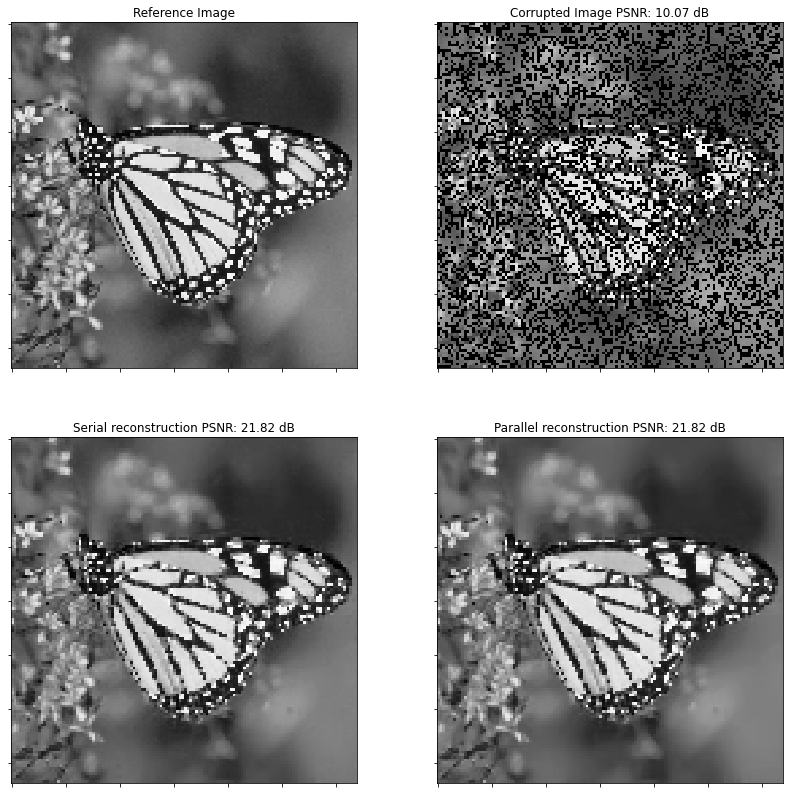

In [13]:
fig = plot.figure(figsize=(14, 14))
plot.subplot(2, 2, 1)
plot.imview(img, fig=fig, title='Reference Image')
plot.subplot(2, 2, 2)
plot.imview(imgw, fig=fig, title=('Corrupted Image PSNR: %5.2f dB' %
            metric.psnr(img, imgw)))
plot.subplot(2, 2, 3)
plot.imview(imgr, fig=fig, title=('Serial reconstruction PSNR: %5.2f dB' %
            metric.psnr(img, imgr)))
plot.subplot(2, 2, 4)
plot.imview(imgr_par, fig=fig, title=('Parallel reconstruction PSNR: %5.2f dB' %
            metric.psnr(img, imgr_par)))
fig.show()

Display lowpass component and sparse representation

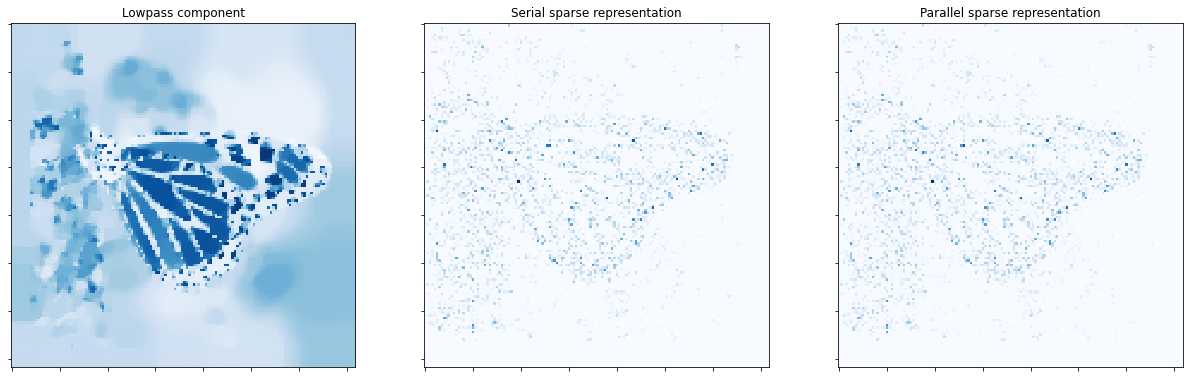

In [14]:
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.imview(sl, fig=fig, cmap=plot.cm.Blues, title='Lowpass component')
plot.subplot(1, 3, 2)
plot.imview(np.squeeze(np.sum(abs(X), axis=b.cri.axisM)), fig=fig,
            cmap=plot.cm.Blues, title='Serial sparse representation')
plot.subplot(1, 3, 3)
plot.imview(np.squeeze(np.sum(abs(X_par), axis=b.cri.axisM)), fig=fig,
            cmap=plot.cm.Blues, title='Parallel sparse representation')
fig.show()